In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 1. Dataset

In [2]:
# Define all image transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#### Trainset

In [3]:
# Get dataset + apply transforms
trainset = torchvision.datasets.CIFAR10(
    root='/tmp/data', train=True,
    download=True, transform=transform)

Files already downloaded and verified


In [4]:
# Dataloader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=8,
    shuffle=True, num_workers=10)

In [5]:
# Preview
for sample in trainloader:
    X = sample[0]
    y = sample[1]
    print(X.size(), y.size())
    print(y)
    break

torch.Size([8, 3, 32, 32]) torch.Size([8])
tensor([2, 3, 9, 9, 3, 9, 3, 7])


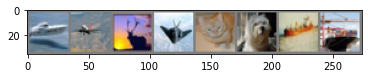

 ship plane  deer plane   cat   dog  ship  ship


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Map labels -> classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

#### Testset

In [7]:
# Get dataset + apply transforms
testset = torchvision.datasets.CIFAR10(
    root='/tmp/data', train=False,
    download=True, transform=transform)

Files already downloaded and verified


In [8]:
# Dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4,
    shuffle=False, num_workers=10)

In [9]:
# Preview
for sample in testloader:
    X = sample[0]
    y = sample[1]
    print(X.size(), y.size())
    print(y)
    break

torch.Size([4, 3, 32, 32]) torch.Size([4])
tensor([3, 8, 8, 0])


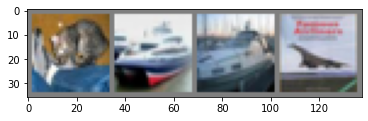

  cat  ship  ship plane


In [10]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Setup GPU

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# Model
net = Net()
net.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 3. Train

In [14]:
%%time
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5000 == 4999:    # print every 5000-th mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Save
PATH = '/tmp/cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  5000] loss: 4.762
[2,  5000] loss: 3.577
[3,  5000] loss: 3.136
[4,  5000] loss: 2.866
[5,  5000] loss: 2.666
[6,  5000] loss: 2.515
[7,  5000] loss: 2.400
[8,  5000] loss: 2.266
[9,  5000] loss: 2.152
[10,  5000] loss: 2.084
[11,  5000] loss: 1.994
[12,  5000] loss: 1.896
[13,  5000] loss: 1.824
[14,  5000] loss: 1.773
[15,  5000] loss: 1.702
[16,  5000] loss: 1.650
[17,  5000] loss: 1.586
[18,  5000] loss: 1.508
[19,  5000] loss: 1.477
[20,  5000] loss: 1.432
Finished Training
CPU times: user 3min 8s, sys: 15.6 s, total: 3min 24s
Wall time: 3min 31s


# 4. Test

In [15]:
# Load Model
net = Net()
net.to(device)

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Test + display 1st batch

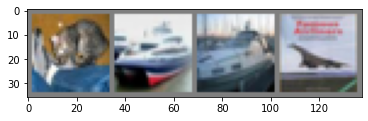

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [16]:
# Get 1st batch
dataiter = iter(testloader)
data = dataiter.next()

images, labels = data[0].to(device), data[1]

# Ground truth
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

#### Test all testloader

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:        
        images, labels = data[0].cuda(), data[1].cuda() 
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


#### get acc of each class

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda() 
        outputs = net(images)
    
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 76 %
Accuracy of  bird : 44 %
Accuracy of   cat : 42 %
Accuracy of  deer : 61 %
Accuracy of   dog : 52 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 74 %
Accuracy of truck : 73 %
